# Campo de gravidade sobre a margem leste brasileira

Este script mostra o campo de gravidade predito pelo modelo global [eigen 6c4](http://icgem.gfz-potsdam.de/ICGEM/documents/Foerste-et-al-EIGEN-6C4.pdf) (Förste et al., 2014). Os coeficientes da expansão em hamônicos esféricos que descreve este modelo global podem ser baixados no site do [IGCEM](http://icgem.gfz-potsdam.de/ICGEM/), na página [Table of models](http://icgem.gfz-potsdam.de/ICGEM/modelstab.html).

* Förste C., Bruinsma S.L., Abrikosov O., Lemoine J.-M., Schaller T., Götze H.-J., Ebbing J., Marty J.C., Flechtner F., Balmino G., Biancale R., 2014, EIGEN-6C4 The latest combined global gravity field model including GOCE data up to degree and order 2190 of GFZ Potsdam and GRGS Toulouse, 5th GOCE User Workshop, Paris, 25-28 November 2014, url: http://icgem.gfz-potsdam.de/ICGEM/documents/Foerste-et-al-EIGEN-6C4.pdf

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap

In [2]:
import fatiando
from fatiando import gridder

In [3]:
import minhas_funcoes as mf

### Função para plotar os estados brasileiros

A função na célula abaixo foi retirada do blog [python4oceanographers](https://ocefpaf.github.io/python4oceanographers/blog/2013/08/12/brazil-states-map/). Os dados `shapefile` com os estados brasileiros foram baixados no site do [Global Administrative Areas](http://www.gadm.org/country).

In [4]:
def drawstates(ax, shapefile='estados_Brasil/BRA_adm0.shp'):
        shp = m.readshapefile(shapefile, 'states', drawbounds=True)
        for nshape, seg in enumerate(m.states):
            poly = Polygon(seg, facecolor='0.75', edgecolor='k')
            ax.add_patch(poly)

### Dados baixados no site do [IGCEM](http://icgem.gfz-potsdam.de/ICGEM/)

#### Topografia/batimetria predita pelo modelo ETOPO1

In [5]:
longitude, latitude, topografia = np.loadtxt('etopo1-18525.gdf.txt', skiprows=29, unpack=True)

In [6]:
topo_positiva = (topografia > 0.)
topo_negativa = (topografia < 0.)

In [7]:
longitude_min = np.min(longitude)
longitude_max = np.max(longitude)

latitude_min = np.min(latitude)
latitude_max = np.max(latitude)

In [8]:
longitude_central = 0.5*(longitude_max + longitude_min)
latitude_central = 0.5*(latitude_max + latitude_min)

In [9]:
area = [longitude_min, longitude_max,
        latitude_min, latitude_max]

In [10]:
area

[319.0, 329.0, -20.0, -6.0]

#### Distúrbio de gravidade

In [11]:
altitude_ortometrica, disturbio = np.loadtxt('eigen-6c4-18527.gdf.txt', skiprows=35, usecols=(2,3), unpack=True)

#### Gravidade

In [12]:
gravidade = np.loadtxt('eigen-6c4-18528.gdf.txt', skiprows=34, usecols=(3,), unpack=True)

### Coordenadas x y da projeção cartográfica

A projeção foi calculada com o [Basemap](http://matplotlib.org/basemap/users/index.html). Para os exemplos mostrados abaixo, a projeção escolhida foi a [Transversa de Mercator](http://matplotlib.org/basemap/users/tmerc.html).

In [13]:
m = Basemap(llcrnrlon=longitude_min,llcrnrlat=latitude_min,
            urcrnrlon=longitude_max,urcrnrlat=latitude_max,
            resolution='i',projection='tmerc',
            lon_0=longitude_central,lat_0=latitude_central)
x, y = m(longitude, latitude)

In [14]:
_ = mf.estatistica(0.001*x, 'km')

     min.:       -30.51359 km
    media:       523.74819 km
     max.:      1078.00996 km
var. max.:      1108.52354 km


In [15]:
_ = mf.estatistica(0.001*y, 'km')

     min.:         0.00000 km
    media:       780.61998 km
     max.:      1556.72636 km
var. max.:      1556.72636 km


### Parâmetros do datum geodésico WGS84

In [16]:
a, f, GM, omega = mf.WGS84()

### Gravidade normal

**Sobre a topografia**

In [17]:
gamma = mf.gamma_closedform(a, f, GM, omega, latitude, altitude_ortometrica)

**Sobre o elipsoide WGS84**

In [18]:
gamma0 = mf.gamma_closedform(a, f, GM, omega, latitude, 
                             np.zeros_like(altitude_ortometrica))

### Anomalias calculadas

**Constante Gravitacional** (ou [*Newtonian constant of gravitation*](http://physics.nist.gov/cgi-bin/cuu/Category?view=html&Universal.x=58&Universal.y=11)) em $\frac{m^{3}}{kg \, s^{2}}$

In [19]:
G = 6.67408e-11

**Correção Ar-livre**

In [20]:
ca = -0.3086*altitude_ortometrica

**Correção de Bouguer (platô)**

Neste cálculo foi considerado uma densidade de $\rho = \rho_{cc} \: \frac{kg}{m^{3}}$ para a correção sobre os continentes (altitudes positivas) e uma densidade de $\rho = (\rho_{co} - \rho_{a})\: \frac{kg}{m^{3}}$ para a correção sobre os oceanos (altitudes negativas), em que $\rho_{cc} = 2670 \: \frac{kg}{m^{3}}$, $\rho_{co} = 2900 \: \frac{kg}{m^{3}}$ e $\rho_{a} = 1025 \: \frac{kg}{m^{3}}$ representam, respectivamente, as densidades da crosta continental, crosta oceânica e da água dos oceanos.

In [21]:
rho_cc = 2670.
rho_co = 2900.
rho_a = 1025.

cb_continente = np.zeros_like(topografia)
cb_continente[topo_positiva] = 2.*np.pi*G*1.0e5*rho_cc*topografia[topo_positiva]

cb_oceano = np.zeros_like(topografia)
cb_oceano[topo_negativa] = 2.*np.pi*G*1.0e5*(rho_co - rho_a)*topografia[topo_negativa]

cb = cb_continente + cb_oceano

**Anomalia Ar-livre**

In [22]:
ar_livre = gravidade - gamma0 - ca

**Anomalia Bouguer (incompleta)**

In [23]:
bouguer = gravidade - gamma0 - ca - cb

**Distúrbio de gravidade**

In [24]:
disturbio_calculado = gravidade - gamma

**Moho isostática (modelo de Airy-Heiskanen)**

O modelo de Airy Heiskanen é um modelo de compensação isostática local, que considera a existência de um espessamento crustal $t_{c}$ sob os continentes e um afinamento crustal $t_{o}$ sob os oceanos. Geralmente, o espessamento crustal é denominado *raiz* e o afinamento crustal é denominado *antirraiz*. Ambos são definidos em relação a uma espessura crustal de referência $T$ e calculados em função da altitude $h$, das densidades $\rho_{cc}$ e $\rho_{co}$ das crostas continental e oceânica, respectivamente, da densidade $\rho_{m}$ do manto e da densidade $\rho_{a}$ da água dos oceanos.

$t_{c} = \dfrac{\rho_{cc}}{\rho_{m} - \rho_{cc}} \, h$, em que $h > 0$ (espessamento sob os continentes)

$t_{o} = \dfrac{\rho_{co} - \rho_{a}}{\rho_{m} - \rho_{co}} \, h$, em que $h < 0$ (afinamento sob os oceanos)

In [25]:
T = 40000.0 # metros

rho_m = 3270.0 

tc = np.zeros_like(topografia)
tc[topo_positiva] = rho_cc*topografia[topo_positiva]/(rho_m - rho_cc)

to = np.zeros_like(topografia)
to[topo_negativa] = (rho_co - rho_a)*topografia[topo_negativa]/(rho_m - rho_co)

moho_ah = T + tc + to

**Correção isostática (Modelo de Airy-Heiskanen com aproximação do platô de Bouguer)**

A correção isostática consiste em remover o efeito gravitacional produzido por ondulações na base da crosta. A correção isostática utilizada neste trabalho é baseada no modelo de Airy-Heiskanen com aproximação do platô de Bouguer. Tal correção tem a seguinte expressão:

$ci_{c} = -2 \pi G \, \rho_{cc} h$, em que $h > 0$ (dados sobre os continentes)

$ci_{o} = 2 \pi G \, \left( \rho_{co} - \rho_{a} \right) h$, em que $h < 0$ (dados sobre o oceano)

In [26]:
cic = np.zeros_like(topografia)
cic[topo_positiva] = 2.*np.pi*G*rho_cc*1.0e5*topografia[topo_positiva]

cio = np.zeros_like(topografia)
cio[topo_negativa] = -2.*np.pi*G*(rho_co - rho_a)*1.0e5*topografia[topo_negativa]

ci = cic + cio

In [27]:
an_isostatica = bouguer - ci

**Pontos iniciais e finais dos perfis analisados**

longitude_tmp, latitude_tmp = np.loadtxt('Linhas_sismicas/0066-0100_lon_lat', usecols=(0,1), unpack=True)
longitudes_perfis = [np.min(longitude_tmp), np.max(longitude_tmp)]
latitudes_perfis = [np.min(latitude_tmp), np.max(latitude_tmp)]

longitude_tmp, latitude_tmp = np.loadtxt('Linhas_sismicas/0259-1401_lon_lat', usecols=(0,1), unpack=True)
longitudes_perfis += [np.min(longitude_tmp), np.max(longitude_tmp)]
latitudes_perfis += [np.min(latitude_tmp), np.max(latitude_tmp)]

longitude_tmp, latitude_tmp = np.loadtxt('Linhas_sismicas/VB00-182_lon_lat', usecols=(0,1), unpack=True)
longitudes_perfis += [np.min(longitude_tmp), np.max(longitude_tmp)]
latitudes_perfis += [np.min(latitude_tmp), np.max(latitude_tmp)]

In [28]:
longitudes_perfis = [360. - 40., 360. - 36.,
                     360. - 38.5, 360. - 34.5,
                     360. - 38., 360. - 34.,
                     360. - 36., 360. - 32.]
latitudes_perfis = [-14., -14.,
                    -12., -14.,
                    -10., -12.,
                    -8.5,  -11.]

In [29]:
longitudes_perfis = np.array(longitudes_perfis)
latitudes_perfis = np.array(latitudes_perfis)

In [30]:
p1, p2 = m(longitudes_perfis, latitudes_perfis)
perfis = np.transpose([p1,p2])

**Perfil 1 (mais ao sul)**

In [31]:
perfil_topografia1 = gridder.profile(x, y, topografia, perfis[0,:], perfis[1,:], 200)

In [32]:
perfil_bouguer1 = gridder.profile(x, y, bouguer, perfis[0,:], perfis[1,:], 200)

In [33]:
perfil_disturbio1 = gridder.profile(x, y, disturbio, perfis[0,:], perfis[1,:], 200)

In [34]:
perfil_moho_ah1 = gridder.profile(x, y, -moho_ah, perfis[0,:], perfis[1,:], 200)

In [35]:
perfil_an_isostatica1 = gridder.profile(x, y, an_isostatica, perfis[0,:], perfis[1,:], 200)

**Perfil 2**

In [36]:
perfil_topografia2 = gridder.profile(x, y, topografia, perfis[2,:], perfis[3,:], 200)

In [37]:
perfil_bouguer2 = gridder.profile(x, y, bouguer, perfis[2,:], perfis[3,:], 200)

In [38]:
perfil_disturbio2 = gridder.profile(x, y, disturbio, perfis[2,:], perfis[3,:], 200)

In [39]:
perfil_moho_ah2 = gridder.profile(x, y, -moho_ah, perfis[2,:], perfis[3,:], 200)

In [40]:
perfil_an_isostatica2 = gridder.profile(x, y, an_isostatica, perfis[2,:], perfis[3,:], 200)

**Perfil 3**

In [41]:
perfil_topografia3 = gridder.profile(x, y, topografia, perfis[4,:], perfis[5,:], 200)

In [42]:
perfil_bouguer3 = gridder.profile(x, y, bouguer, perfis[4,:], perfis[5,:], 200)

In [43]:
perfil_disturbio3 = gridder.profile(x, y, disturbio, perfis[4,:], perfis[5,:], 200)

In [44]:
perfil_moho_ah3 = gridder.profile(x, y, -moho_ah, perfis[4,:], perfis[5,:], 200)

In [45]:
perfil_an_isostatica3 = gridder.profile(x, y, an_isostatica, perfis[4,:], perfis[5,:], 200)

**Perfil 4 (mais ao norte)**

In [46]:
perfil_topografia4 = gridder.profile(x, y, topografia, perfis[6,:], perfis[7,:], 200)

In [47]:
perfil_bouguer4 = gridder.profile(x, y, bouguer, perfis[6,:], perfis[7,:], 200)

In [48]:
perfil_disturbio4 = gridder.profile(x, y, disturbio, perfis[6,:], perfis[7,:], 200)

In [49]:
perfil_moho_ah4 = gridder.profile(x, y, -moho_ah, perfis[6,:], perfis[7,:], 200)

In [50]:
perfil_an_isostatica4 = gridder.profile(x, y, an_isostatica, perfis[6,:], perfis[7,:], 200)

### Estatísticas e "mapas"

In [51]:
topografia_min, topografia_media, topografia_max, topografia_var = mf.estatistica(topografia, 'm')

     min.:     -5573.00000 m
    media:     -2371.88547 m
     max.:      1031.00000 m
var. max.:      6604.00000 m


C:\Anaconda\lib\site-packages\matplotlib\tri\triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)
minhas_funcoes.py:266: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if perfis != None:


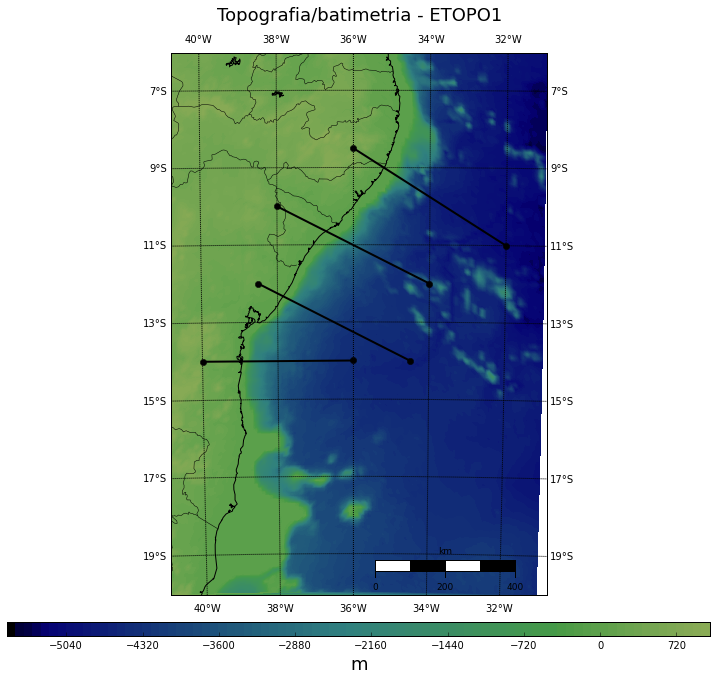

In [52]:
mf.plota_mapa(m, x, y, topografia, area, 'm', 'Topografia/batimetria - ETOPO1', 'gist_earth', 
              (18, 12), 2., perfis, estados=True, escala=True, eixos=True)

In [53]:
disturbio_min, disturbio_medio, disturbio_max, disturbio_var = mf.estatistica(disturbio, 'mGal')

     min.:      -121.19740 mGal
    media:        -6.40305 mGal
     max.:       273.25794 mGal
var. max.:       394.45535 mGal


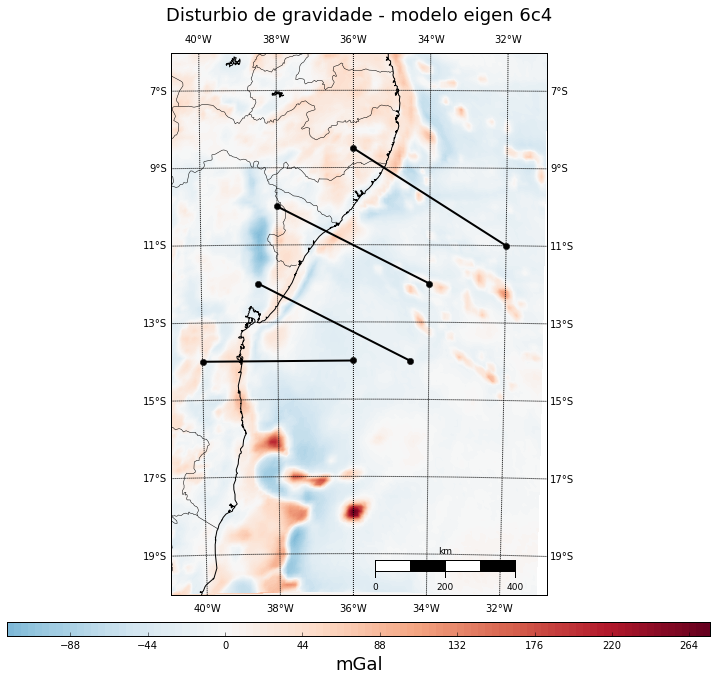

In [54]:
mf.plota_mapa(m, x, y, disturbio, area, 'mGal', 'Disturbio de gravidade - modelo eigen 6c4', 'RdBu_r',
              (18, 12), 2., perfis, estados=True, escala=True, eixos=True)

In [55]:
disturbio_calc_min, disturbio_calc_medio, disturbio_calc_max, disturbio_calc_var = mf.estatistica(disturbio_calculado, 'mGal')

     min.:      -118.10178 mGal
    media:        -3.63736 mGal
     max.:       274.22182 mGal
var. max.:       392.32359 mGal


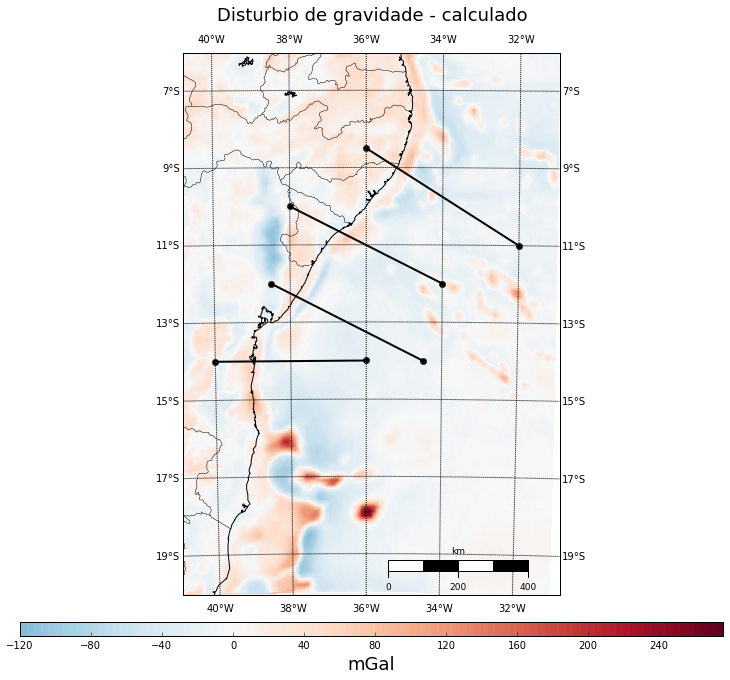

In [56]:
mf.plota_mapa(m, x, y, disturbio_calculado, area, 'mGal', 'Disturbio de gravidade - calculado', 'RdBu_r',
              (18, 12), 2., perfis, estados=True, escala=True, eixos=True)

In [57]:
ar_livre_min, ar_livre_medio, ar_livre_max, ar_livre_var = mf.estatistica(ar_livre, 'mGal')

     min.:      -118.10178 mGal
    media:        -3.65334 mGal
     max.:       274.22182 mGal
var. max.:       392.32359 mGal


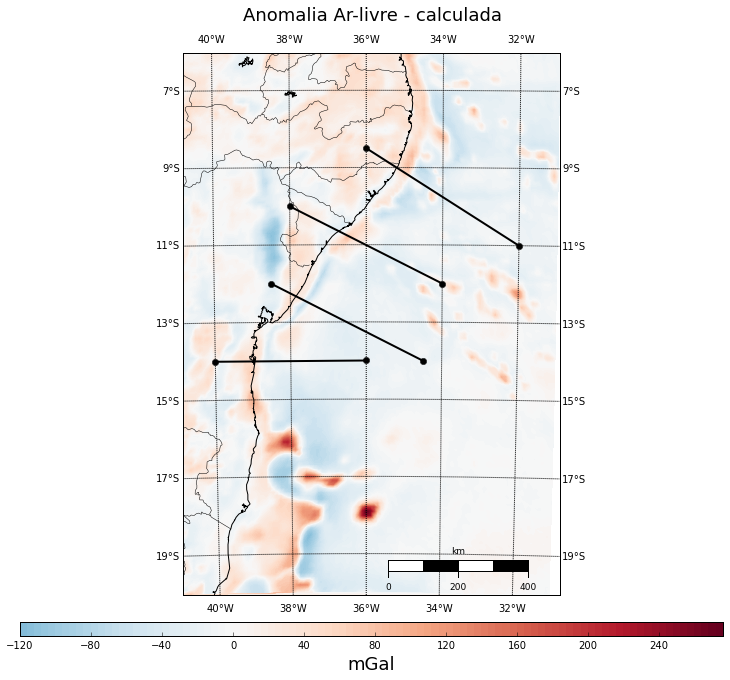

In [58]:
mf.plota_mapa(m, x, y, ar_livre, area, 'mGal', 'Anomalia Ar-livre - calculada', 'RdBu_r',
              (18, 12), 2., perfis, estados=True, escala=True, eixos=True)

In [59]:
bouguer_min, bouguer_medio, bouguer_max, bouguer_var = mf.estatistica(bouguer, 'mGal')

     min.:      -152.66894 mGal
    media:       178.69820 mGal
     max.:       413.98139 mGal
var. max.:       566.65032 mGal


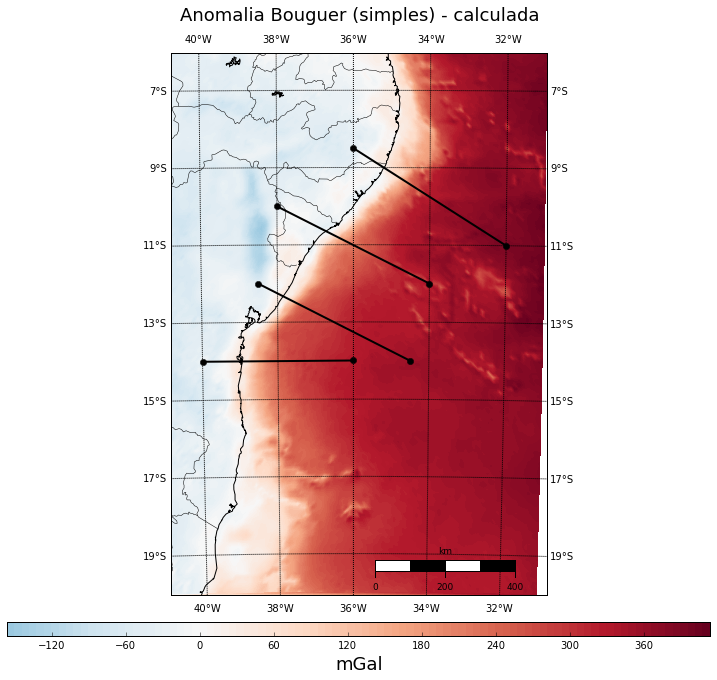

In [60]:
mf.plota_mapa(m, x, y, bouguer, area, 'mGal', 'Anomalia Bouguer (simples) - calculada', 'RdBu_r',
              (18, 12), 2., perfis, estados=True, escala=True, eixos=True)

In [61]:
moho_ah_min, moho_ah_media, moho_ah_max, moho_ah_var = mf.estatistica(moho_ah, 'm')

     min.:     11758.44595 m
    media:     27903.56200 m
     max.:     44587.95000 m
var. max.:     32829.50405 m


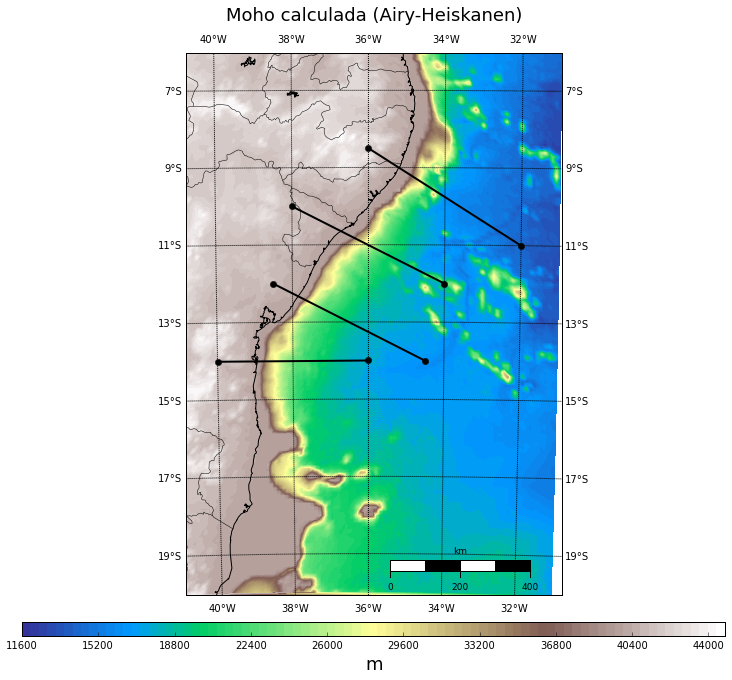

In [62]:
mf.plota_mapa(m, x, y, moho_ah, area, 'm', 'Moho calculada (Airy-Heiskanen)', 'terrain',
              (18, 12), 2., perfis, estados=True, escala=True, eixos=True)

In [63]:
an_isostatica_min, an_isostatica_media, an_isostatica_max, an_isostatica_var = mf.estatistica(an_isostatica, 'm')

     min.:      -202.15862 m
    media:       -31.48222 m
     max.:       274.22182 m
var. max.:       476.38044 m


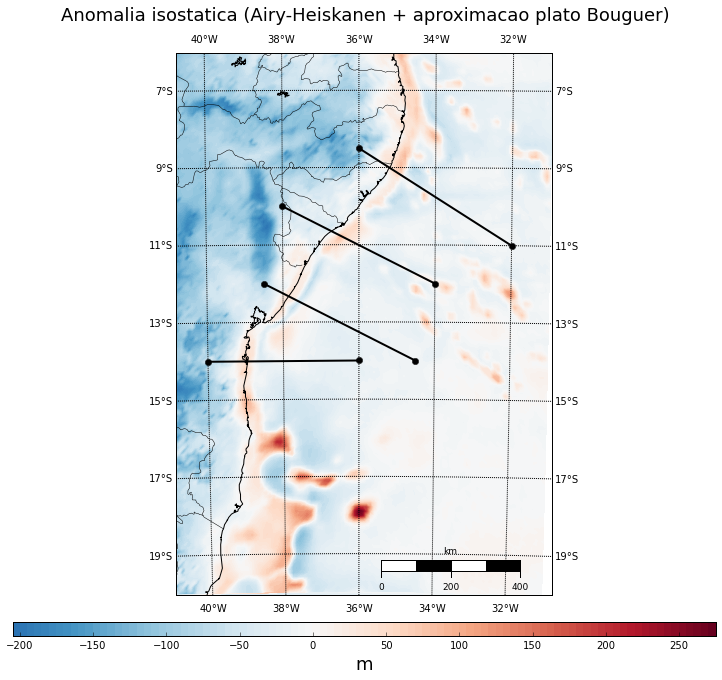

In [64]:
mf.plota_mapa(m, x, y, an_isostatica, area, 'm', 'Anomalia isostatica (Airy-Heiskanen + aproximacao plato Bouguer)', 'RdBu_r',
              (18, 12), 2., perfis, estados=True, escala=True, eixos=True)

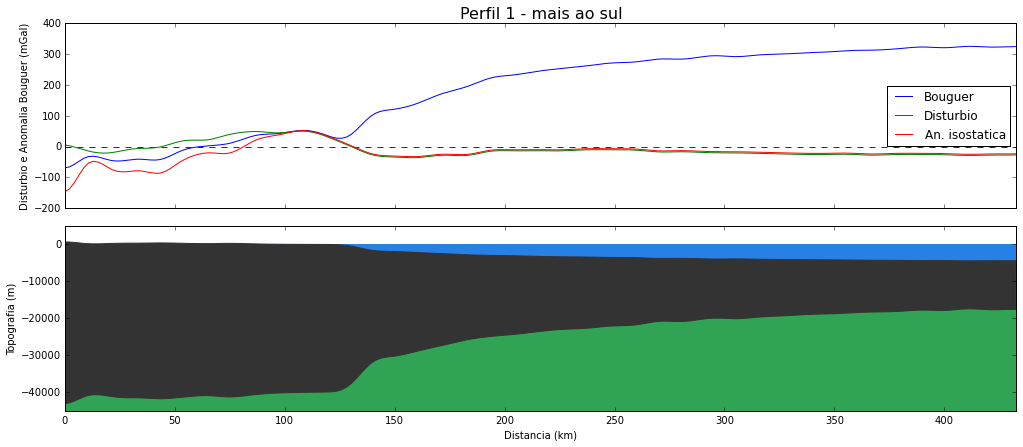

In [72]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14, 6))
ax1, ax2 = axes
d = perfil_topografia1[2]*0.001
ax2.fill_between([d.min(), d.max()], [0, 0], -6000, color='#2780E3')
ax2.fill_between([d.min(), d.max()], -6000, -45000, color='#31a354')
ax2.fill_between(d, perfil_topografia1[3], perfil_moho_ah1[3], color='#333333')
ax2.set_ylabel('Topografia (m)')
ax2.set_xlabel('Distancia (km)')
ax2.set_ylim(-45000., 5000.)

ax1.set_title('Perfil 1 - mais ao sul', fontsize=16)
ax1.set_ylabel('Disturbio e Anomalia Bouguer (mGal)')
ax1.plot(d, perfil_bouguer1[3], '-', label='Bouguer')
ax1.plot(d, perfil_disturbio1[3], '-', label='Disturbio')
ax1.plot(d, perfil_an_isostatica1[3], '-', label='An. isostatica')
ax1.hlines(0, d.min(), d.max(), linestyles='--', color='#333333')
ax1.legend(loc='center right')
ax1.set_xlim(d.min(), d.max())
plt.tight_layout(h_pad=0, w_pad=0, pad=0)
plt.show()

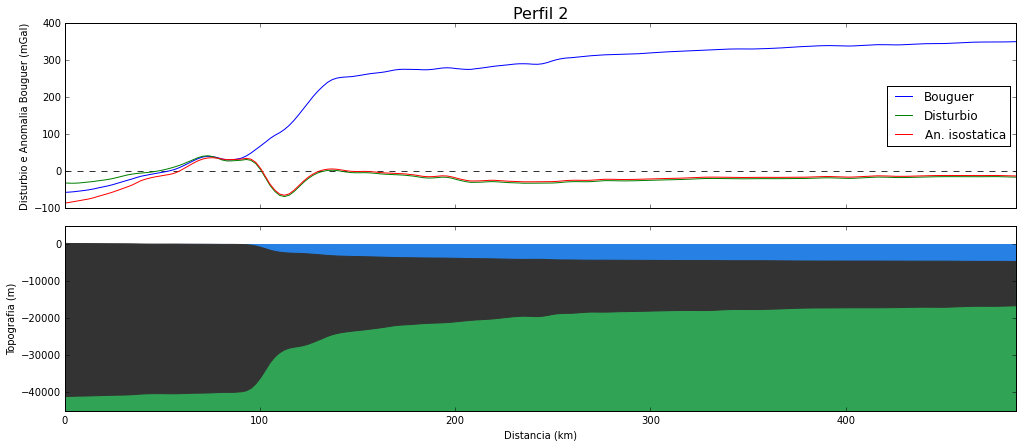

In [73]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14, 6))
ax1, ax2 = axes
d = perfil_topografia2[2]*0.001
ax2.fill_between([d.min(), d.max()], [0, 0], -6000, color='#2780E3')
ax2.fill_between([d.min(), d.max()], -6000, -45000, color='#31a354')
ax2.fill_between(d, perfil_topografia2[3], perfil_moho_ah2[3], color='#333333')
ax2.set_ylabel('Topografia (m)')
ax2.set_xlabel('Distancia (km)')
ax2.set_ylim(-45000., 5000.)

ax1.set_title('Perfil 2', fontsize=16)
ax1.set_ylabel('Disturbio e Anomalia Bouguer (mGal)')
ax1.plot(d, perfil_bouguer2[3], '-', label='Bouguer')
ax1.plot(d, perfil_disturbio2[3], '-', label='Disturbio')
ax1.plot(d, perfil_an_isostatica2[3], '-', label='An. isostatica')
ax1.hlines(0, d.min(), d.max(), linestyles='--', color='#333333')
ax1.legend(loc='center right')
ax1.set_xlim(d.min(), d.max())
plt.tight_layout(h_pad=0, w_pad=0, pad=0)
plt.show()

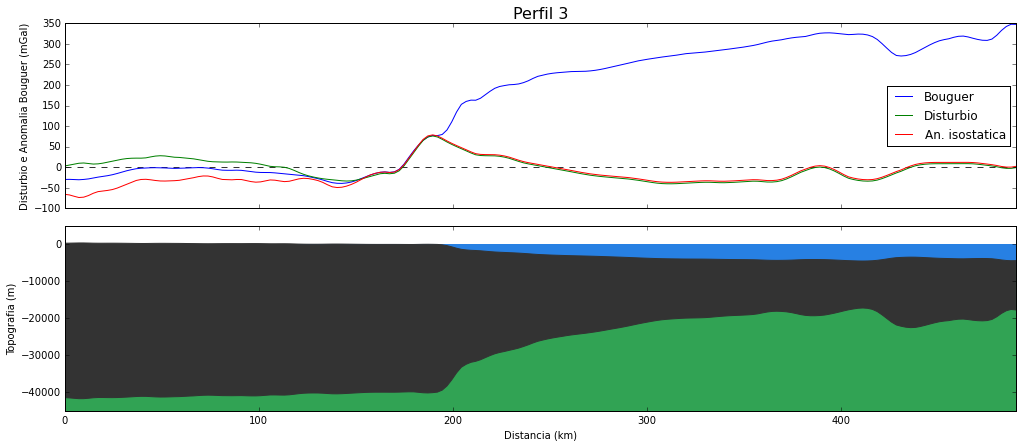

In [74]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14, 6))
ax1, ax2 = axes
d = perfil_topografia3[2]*0.001
ax2.fill_between([d.min(), d.max()], [0, 0], -6000, color='#2780E3')
ax2.fill_between([d.min(), d.max()], -6000, -45000, color='#31a354')
ax2.fill_between(d, perfil_topografia3[3], perfil_moho_ah3[3], color='#333333')
ax2.set_ylabel('Topografia (m)')
ax2.set_xlabel('Distancia (km)')
ax2.set_ylim(-45000., 5000.)

ax1.set_title('Perfil 3', fontsize=16)
ax1.set_ylabel('Disturbio e Anomalia Bouguer (mGal)')
ax1.plot(d, perfil_bouguer3[3], '-', label='Bouguer')
ax1.plot(d, perfil_disturbio3[3], '-', label='Disturbio')
ax1.plot(d, perfil_an_isostatica3[3], '-', label='An. isostatica')
ax1.hlines(0, d.min(), d.max(), linestyles='--', color='#333333')
ax1.legend(loc='center right')
ax1.set_xlim(d.min(), d.max())
plt.tight_layout(h_pad=0, w_pad=0, pad=0)
plt.show()

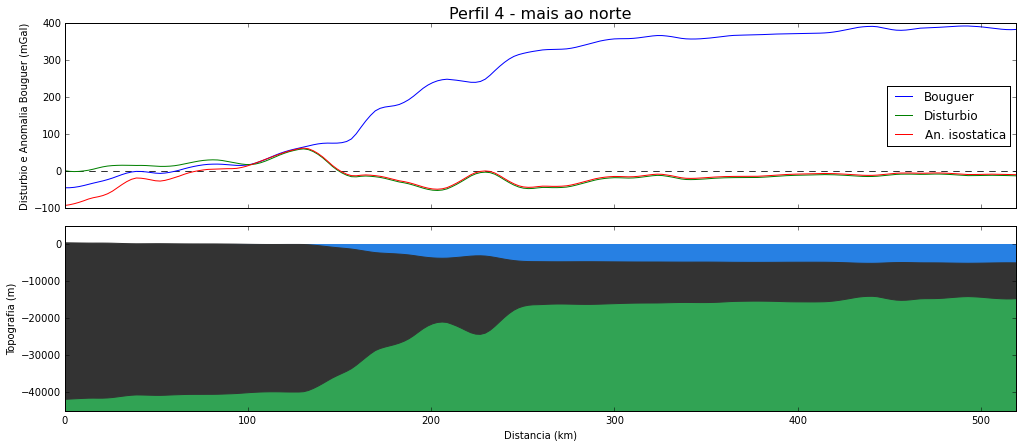

In [75]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14, 6))
ax1, ax2 = axes
d = perfil_topografia4[2]*0.001
ax2.fill_between([d.min(), d.max()], [0, 0], -6000, color='#2780E3')
ax2.fill_between([d.min(), d.max()], -6000, -45000, color='#31a354')
ax2.fill_between(d, perfil_topografia4[3], perfil_moho_ah4[3], color='#333333')
ax1.hlines(0, d.min(), d.max(), linestyles='--', color='#333333')
ax2.set_ylabel('Topografia (m)')
ax2.set_xlabel('Distancia (km)')
ax2.set_ylim(-45000., 5000.)

ax1.set_title('Perfil 4 - mais ao norte', fontsize=16)
ax1.set_ylabel('Disturbio e Anomalia Bouguer (mGal)')
ax1.plot(d, perfil_bouguer4[3], '-', label='Bouguer')
ax1.plot(d, perfil_disturbio4[3], '-', label='Disturbio')
ax1.plot(d, perfil_an_isostatica4[3], '-', label='An. isostatica')
ax1.hlines(0, d.min(), d.max(), linestyles='--', color='#333333')
ax1.legend(loc='center right')
ax1.set_xlim(d.min(), d.max())
plt.tight_layout(h_pad=0, w_pad=0, pad=0)
plt.show()

In [69]:
diferenca1 = perfil_an_isostatica1[3] - perfil_disturbio1[3]
diferenca2 = perfil_an_isostatica2[3] - perfil_disturbio2[3]
diferenca3 = perfil_an_isostatica3[3] - perfil_disturbio3[3]
diferenca4 = perfil_an_isostatica4[3] - perfil_disturbio4[3]

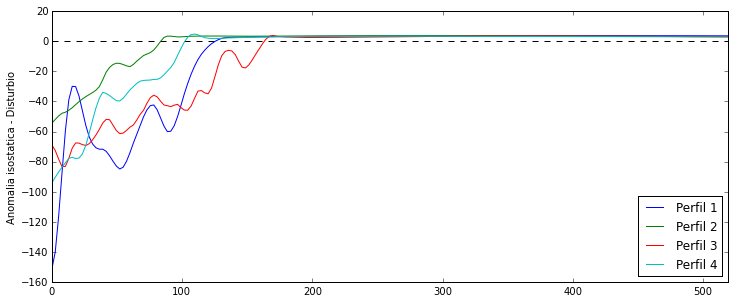

In [70]:
plt.figure(figsize=(10, 4))
plt.ylabel('Anomalia isostatica - Disturbio')
plt.plot(d, diferenca1, '-', label='Perfil 1')
plt.plot(d, diferenca2, '-', label='Perfil 2')
plt.plot(d, diferenca3, '-', label='Perfil 3')
plt.plot(d, diferenca4, '-', label='Perfil 4')
plt.hlines(0.0, d.min(), d.max(), linestyles='--', color='k')
plt.legend(loc='best')
plt.xlim(d.min(), d.max())
plt.tight_layout(h_pad=0, w_pad=0, pad=0)
plt.show()

Todos os perfis mostrados acima começam no continente e terminam no oceano. Os perfis 1, 2, 3 e 4 estão dispostos, respectivamente, de sul para norte.